In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
import statsmodels.api as sm
from colorama import Fore, Style
from scipy.optimize import fsolve, curve_fit
import yfinance as yf
import akshare as ak
import sys
sys.path.append('../src') 
from utils import plot_candlestick, get_optimum_clusters, exponential_func

from chinese_index_etf_strategy import etf_strategy, etf_regression
from chinese_commodity_strategy import commodity_strategy

## Some sample code that're working

Index(['日期', '指数代码', '指数中文全称', '指数中文简称', '指数英文全称', '指数英文简称', '开盘', '最高', '最低',
       '收盘', '涨跌', '涨跌幅', '成交量', '成交金额', '样本数量', '滚动市盈率'],
      dtype='object')
* Recent high: 6209.67
Latest 20 Day MA: 5531.76
Latest lower Bollinger Band, 20MA: 5434.56
Latest higher Bollinger Band, 20MA: 5628.96
Latest 50 Day MA: 5555.77
Latest lower Bollinger Band, 50MA: 5419.28
Latest higher Bollinger Band, 50MA: 5692.26
Latest 50 Day EMA: 5531.1
Latest 120 Day MA: 5481.9
Latest 200 Day MA: 5451.28
Latest 200 Day EMA: 5454.06
Latest 10 Week MA: 5544.04
Latest 20 Week MA: 5498.93
Latest 30 Week MA: 5460.97
Latest 40 Week MA: 5438.58
Latest Lower Weekly Bollinger Band, 20MA: 5360.35
Latest Higher Weekly Bollinger Band, 20MA: 5637.52

Latest RSI: 42.9 
Latest MACD Divergence: -8.6536 


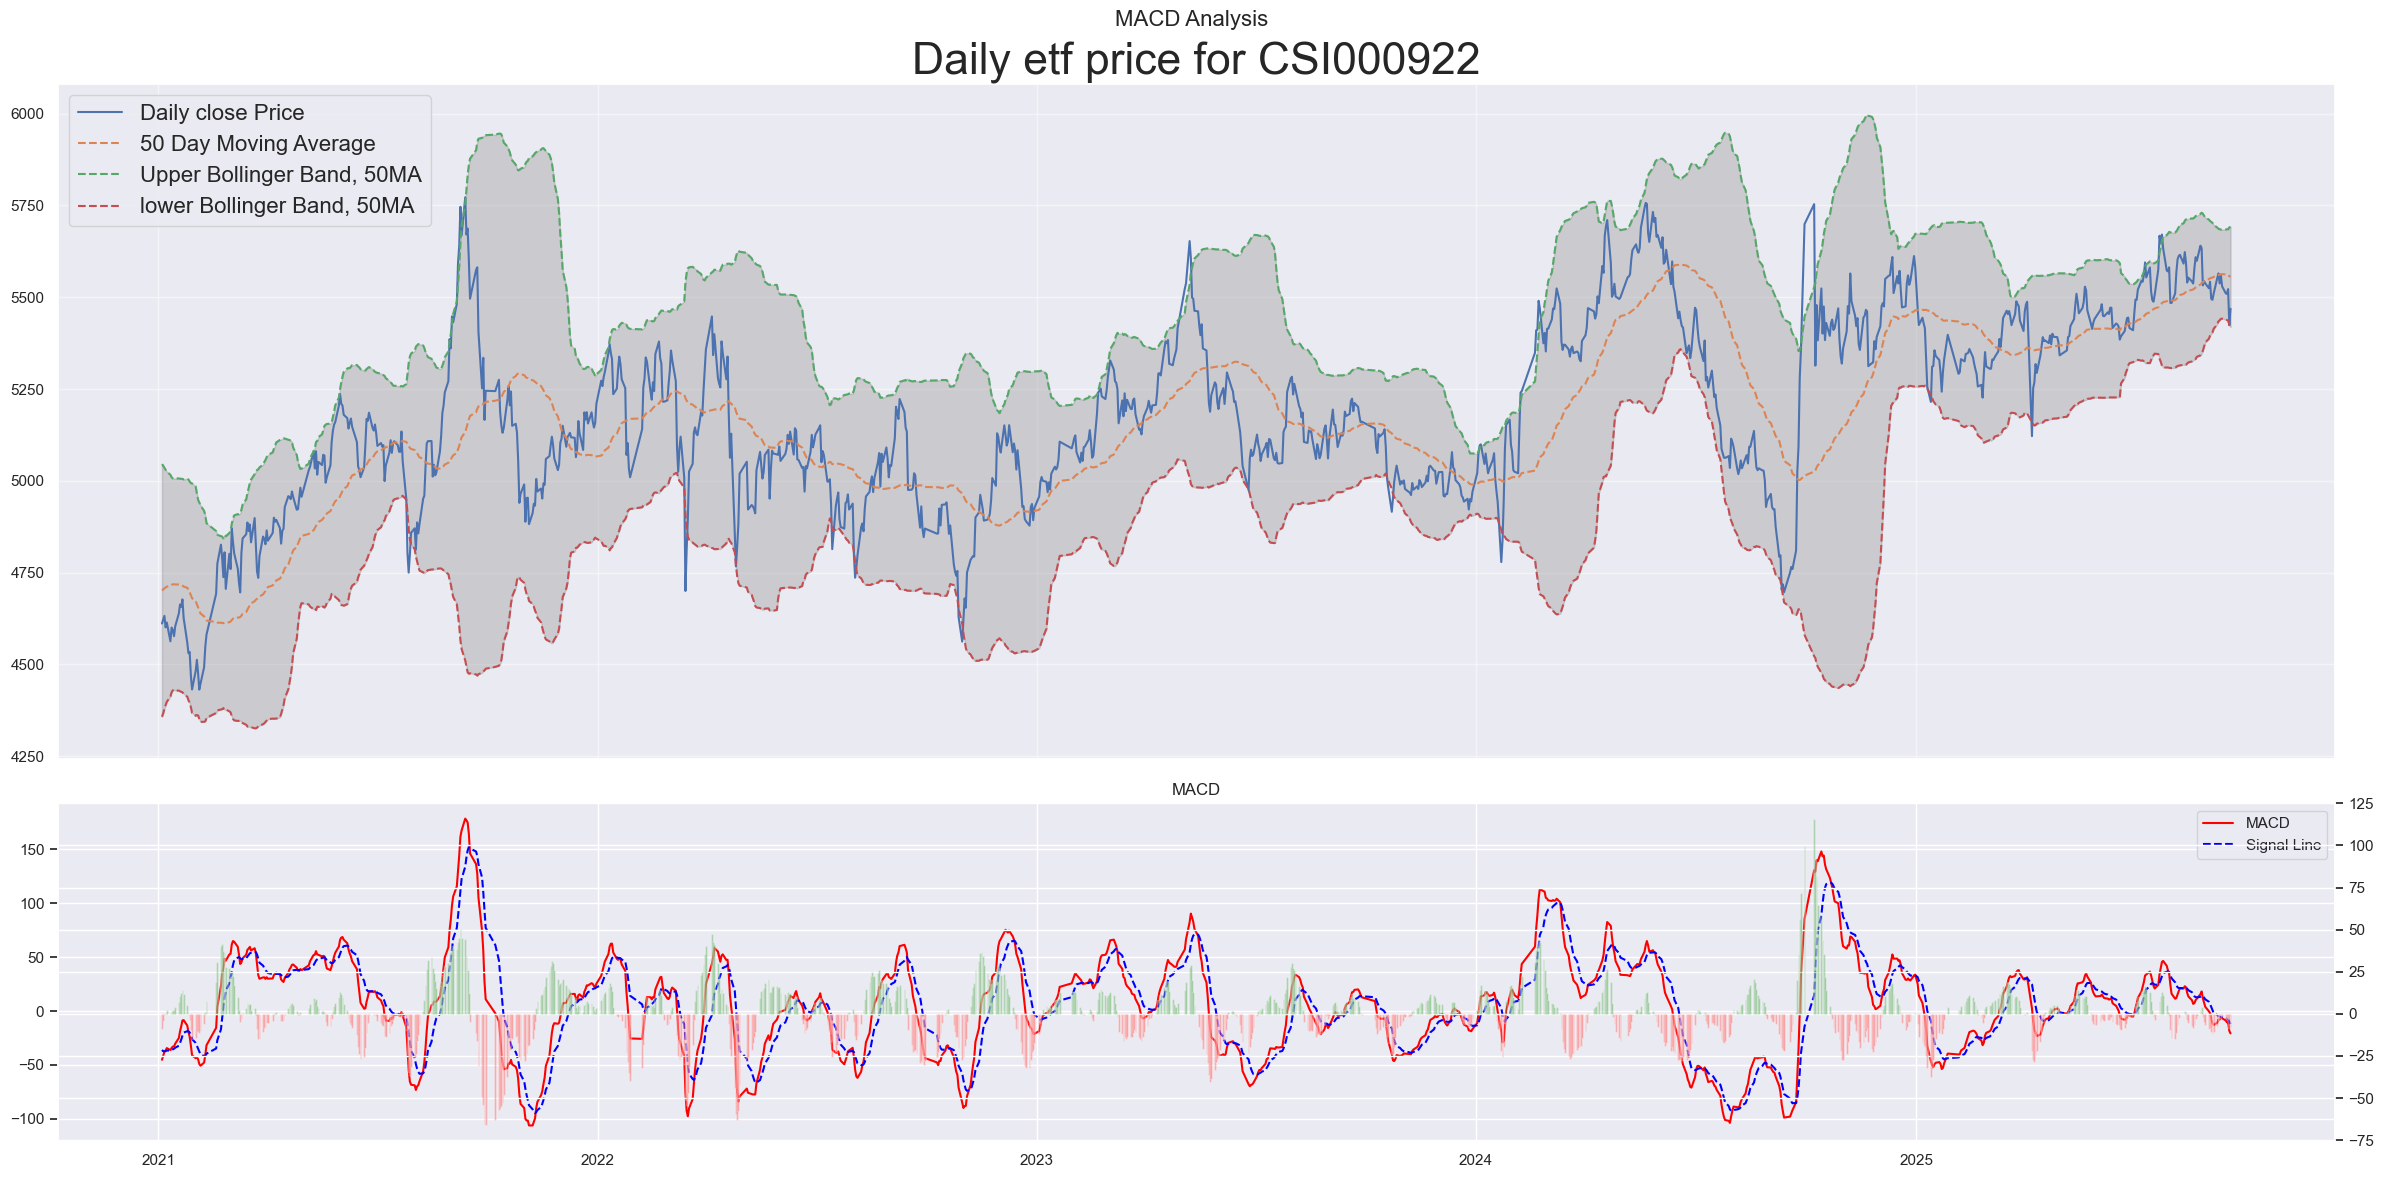

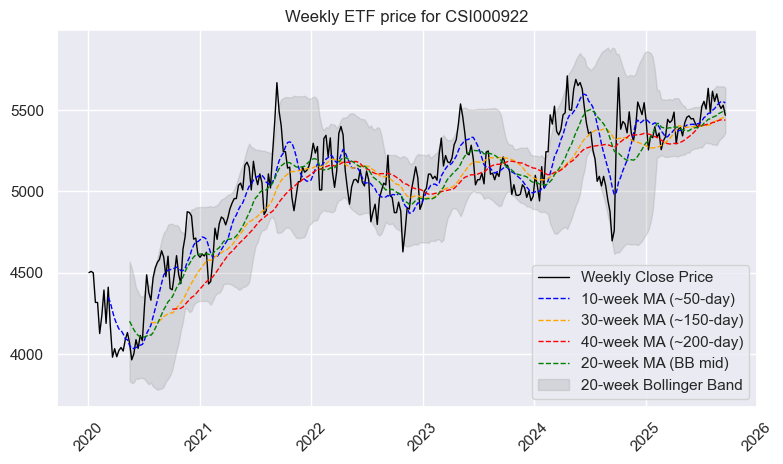

In [4]:
# 红利指数
etf_code = 'csi000922'
df = ak.stock_zh_index_hist_csindex(symbol="000922", start_date="20200101", end_date="20250922")
print(df.columns)
df.rename(columns={"日期": 'date', "开盘": 'open', "收盘": 'close', "最高": 'high', "最低": 'low', "成交量": 'volume', "成交额": 'amount'}, inplace=True)
df['date'] = pd.to_datetime(df['date']) 
df = df[['date', 'open', 'high', 'low', 'close', 'volume']]
df.dropna(inplace=True)

saturation_point = 0.05
previous_day = df['date'].max()
from utils import plot_candlestick, exponential_func, get_optimum_clusters

df['12 Day EMA'] = df['close'].ewm(span=12, adjust=False).mean()
df['26 Day EMA'] = df['close'].ewm(span=26, adjust=False).mean()
df['50 Day EMA'] = df['close'].ewm(span=50, adjust=False).mean()
df['200 Day EMA'] = df['close'].ewm(span=200, adjust=False).mean()

'''
Create 20 Day MA, 50 Day MA, and their corresponding Bollinger Bands
'''
df['20 Day MA'] = df['close'].rolling(window=20).mean()
daily_std20 = df['close'].rolling(window=20).std()
df['Upper Band - 20MA'] = df['20 Day MA'] + (daily_std20 * 2)
df['lower Band - 20MA'] = df['20 Day MA'] - (daily_std20 * 2)
df['50 Day MA'] = df['close'].rolling(window=50).mean()
daily_std50 = df['close'].rolling(window=50).std()
df['Upper Band - 50MA'] = df['50 Day MA'] + (daily_std50 * 2.5)
df['lower Band - 50MA'] = df['50 Day MA'] - (daily_std50 * 2.5)
df['120 Day MA'] = df['close'].rolling(window=120).mean()
df['200 Day MA'] = df['close'].rolling(window=200).mean()

# Calculate weekly MA
weekly = df[['date', 'close']].set_index('date')['close'].resample("W-FRI").ffill()
weekly_ma10 = weekly.rolling(10).mean()
weekly_ma30 = weekly.rolling(30).mean()
weekly_ma40 = weekly.rolling(40).mean()

# Weekly Bollinger Bands (20-week)
weekly_ma20 = weekly.rolling(20).mean()
weekly_std20 = weekly.rolling(20).std()
weekly_bb_upper = weekly_ma20 + 2 * weekly_std20
weekly_bb_lower = weekly_ma20 - 2 * weekly_std20

'''
Calculate RSI
'''
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

'''
Create MACD using 12 Day EMA and 26 Day EMA
'''
# Calculate MACD line
df['MACD'] = df['12 Day EMA'] - df['26 Day EMA']
# Calculate signal line (9-period EMA of MACD line)
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_diff'] = df['MACD'] - df['MACD_signal']

'''
Calculate support and resistance using KMean
'''
if df[df['date'] >= df['date'].min() + relativedelta(years=1)].shape[0] > 0:
    df_plot = df[df['date'] >= df['date'].min() + relativedelta(years=1)]
else:
    df_plot = df
low_clusters = get_optimum_clusters(df_plot[(df_plot['low']!=df_plot['open'])&(df_plot['low']!=df_plot['close'])][['date',"low"]].set_index('date'), saturation_point)
# low_clusters = get_optimum_clusters(df_plot[['date',"low"]].set_index('date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df_plot[(df_plot['high']!=df_plot['open'])&(df_plot['high']!=df_plot['close'])][['date',"high"]].set_index('date'), saturation_point)
# high_clusters = get_optimum_clusters(df_plot[['date',"high"]].set_index('date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print('* Recent high:', round(df_plot['high'].max(),2))
print("Latest 20 Day MA:", round(df[df['date']==previous_day]['20 Day MA'].item(), 2))
print("Latest lower Bollinger Band, 20MA:", round(df[df['date']==previous_day]['lower Band - 20MA'].item(), 2))
print("Latest higher Bollinger Band, 20MA:", round(df[df['date']==previous_day]['Upper Band - 20MA'].item(), 2))
print("Latest 50 Day MA:", round(df[df['date']==previous_day]['50 Day MA'].item(), 2))
print("Latest lower Bollinger Band, 50MA:", round(df[df['date']==previous_day]['lower Band - 50MA'].item(), 2))
print("Latest higher Bollinger Band, 50MA:", round(df[df['date']==previous_day]['Upper Band - 50MA'].item(), 2))
print("Latest 50 Day EMA:", round(df[df['date']==previous_day]['50 Day EMA'].item(), 2))
print("Latest 120 Day MA:", round(df[df['date']==previous_day]['120 Day MA'].item(), 2))
print("Latest 200 Day MA:", round(df[df['date']==previous_day]['200 Day MA'].item(), 2))
print("Latest 200 Day EMA:", round(df[df['date']==previous_day]['200 Day EMA'].item(), 2))

print("Latest 10 Week MA:", round(weekly_ma10.iloc[-1], 2))
print("Latest 20 Week MA:", round(weekly_ma20.iloc[-1], 2))
print("Latest 30 Week MA:", round(weekly_ma30.iloc[-1], 2))
print("Latest 40 Week MA:", round(weekly_ma40.iloc[-1], 2))
print("Latest Lower Weekly Bollinger Band, 20MA:", round(weekly_bb_lower.iloc[-1], 2))
print("Latest Higher Weekly Bollinger Band, 20MA:", round(weekly_bb_upper.iloc[-1], 2))
print()

latest_rsi = round(df[df['date']==previous_day]['RSI'].item(), 2)
if latest_rsi > 70:
    print("Latest RSI:", Fore.RED + str(latest_rsi), Style.RESET_ALL)
elif latest_rsi < 30:
    print("Latest RSI:", Fore.GREEN + str(latest_rsi), Style.RESET_ALL)
else:
    print("Latest RSI:", latest_rsi, Style.RESET_ALL)

latest_macd = round(df[df['date']==previous_day]['MACD_diff'].item(), 4)
if latest_macd < 0:
    print("Latest MACD Divergence:", Fore.RED + str(latest_macd), Style.RESET_ALL)
elif latest_macd > 0:
    print("Latest MACD Divergence:", Fore.GREEN + str(latest_macd), Style.RESET_ALL)
else:
    print("Latest MACD Divergence:", Fore.BLACK + str(latest_macd), Style.RESET_ALL)

figsize=(24, 12)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
ax1.grid(True, alpha=0.5)
ax1.plot(df_plot['date'], df_plot['close'], label='Daily close Price')
ax1.plot(df_plot['date'], df_plot['50 Day MA'], ls='--', label='50 Day Moving Average')
ax1.plot(df_plot['date'], df_plot['Upper Band - 50MA'], ls='--', label='Upper Bollinger Band, 50MA')
ax1.plot(df_plot['date'], df_plot['lower Band - 50MA'], ls='--', label='lower Bollinger Band, 50MA')
ax1.fill_between(df_plot['date'], df_plot['Upper Band - 50MA'], df_plot['lower Band - 50MA'], color='gray', alpha=0.3) # Fill the area between the bands
ax1.set_title('Daily etf price for ' + etf_code.upper(), fontsize=32)
ax1.legend(fontsize=16)

# Plot MACD and signal line, color bars based on MACD above/below signal line
ax2.plot(df_plot['date'], df_plot['MACD'], label='MACD', color='red')
ax2.plot(df_plot['date'], df_plot['MACD_signal'], label='Signal Line', linestyle='--', color='blue')
bar_colors = ['green' if macd > signal else 'red' for macd, signal in zip(df_plot['MACD'], df_plot['MACD_signal'])]
ax3 = ax2.twinx()
ax3.bar(df_plot['date'], df_plot['MACD'] - df_plot['MACD_signal'], width=1.5,  alpha=0.3, align='center', color=bar_colors)        
ax2.set_title('MACD')
ax2.legend()
fig.suptitle('MACD Analysis', fontsize=16)
fig.subplots_adjust(hspace=0.05)  # Reduce vertical space between subplots
plt.xticks(rotation=45)  

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4.8))
plt.plot(weekly.index, weekly, label="Weekly Close Price", color="black", linewidth=1)
plt.plot(weekly_ma10.index, weekly_ma10, label="10-week MA (~50-day)", ls='--', color="blue", linewidth=1)
plt.plot(weekly_ma30.index, weekly_ma30, label="30-week MA (~150-day)", ls='--', color="orange", linewidth=1)
plt.plot(weekly_ma40.index, weekly_ma40, label="40-week MA (~200-day)", ls='--', color="red", linewidth=1)

plt.plot(weekly_ma20.index, weekly_ma20, label="20-week MA (BB mid)", ls='--', color="green", linewidth=1)
plt.fill_between(weekly_bb_upper.index, weekly_bb_lower, weekly_bb_upper, color="gray", alpha=0.2, label="20-week Bollinger Band")

plt.title(f'Weekly ETF price for {etf_code.upper()}')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

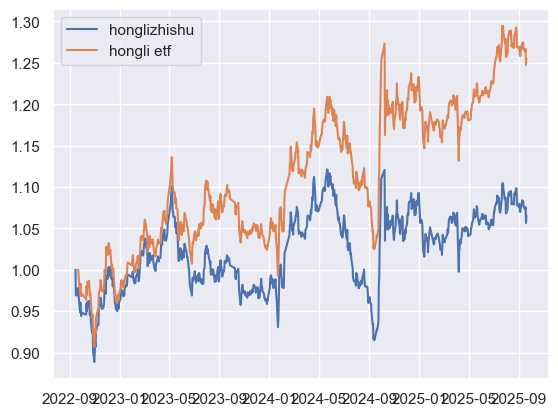

In [5]:
df_plot = df[df['date']>='2022-09-15']
plt.plot(df_plot['date'], df_plot['close'] / df_plot.iloc[0]['close'], label='honglizhishu')
etf_code = '515180'
df_1 = etf_strategy(etf_code).df
plt.plot(df_1['date'], df_1['close'] / df_1.iloc[0]['close'], label='hongli etf')
plt.legend()

In [8]:
# Tongxin ETF, changnei, history
etf_code = "sh515880"  # ETF代码
etf_hist = ak.fund_etf_hist_sina(symbol=etf_code)
etf_hist.tail()

,date,open,high,low,close,volume
1461,2025-09-16,2.573,2.623,2.531,2.596,673476525
1462,2025-09-17,2.580,2.625,2.535,2.605,645840882
1463,2025-09-18,2.562,2.724,2.560,2.655,942795427
1464,2025-09-19,2.686,2.730,2.634,2.681,678130073
1465,2025-09-22,2.682,2.724,2.603,2.712,544122882


In [9]:
# Tongxin ETF, changnei, realtime
df = ak.fund_etf_spot_ths()
df[df['基金代码']=='515880']

,序号,基金代码,基金名称,当前-单位净值,当前-累计净值,前一日-单位净值,前一日-累计净值,增长值,增长率,赎回状态,申购状态,最新-交易日,最新-单位净值,最新-累计净值,基金类型,查询日期
280,281,515880,国泰中证全指通信设备ETF,2.7127,2.7127,2.6792,2.6792,0.0335,1.25,开放,开放,2025-09-22,2.7127,2.7127,股票型,2025-09-22


In [10]:
# Tongxin ETF, changnei, lishi and shishi
etf_code = "515880"  # ETF代码
start_date = (datetime.today() - relativedelta(years=3)).strftime('%Y%m%d')   # 开始日期
end_date = datetime.today().strftime('%Y%m%d')  # 结束日期

etf_hist = ak.fund_etf_hist_em(symbol=etf_code, period="daily", start_date=start_date, end_date=end_date, adjust="")
etf_hist.rename(columns={"日期": 'date', "开盘": 'open', "收盘": 'close', "最高": 'high', "最低": 'low', "成交量": 'volume', "成交额": 'amount'}, inplace=True)
etf_hist.tail()

,date,open,close,high,low,volume,amount,振幅,涨跌幅,涨跌额,换手率
723,2025-09-16,2.573,2.596,2.623,2.531,6734765,1.737469e+09,3.57,0.74,0.019,15.52
724,2025-09-17,2.580,2.605,2.625,2.535,6458409,1.672540e+09,3.47,0.35,0.009,14.89
725,2025-09-18,2.562,2.655,2.724,2.560,9427954,2.500809e+09,6.30,1.92,0.050,21.73
726,2025-09-19,2.686,2.681,2.730,2.634,6781301,1.818438e+09,3.62,0.98,0.026,15.63
727,2025-09-22,2.682,2.712,2.724,2.603,5441229,1.460438e+09,4.51,1.16,0.031,12.54


In [11]:
# Huangjin, history
spot_hist_sge_df = ak.spot_hist_sge(symbol='Au99.99')
spot_hist_sge_df['date']= pd.to_datetime(spot_hist_sge_df['date'])
spot_hist_sge_df.tail()

,date,open,close,low,high
2123,2025-09-16,829.0,838.73,829.0,839.99
2124,2025-09-17,838.7,831.85,831.4,841.00
2125,2025-09-18,832.8,824.59,822.0,837.00
2126,2025-09-19,830.0,826.71,823.0,830.00
2127,2025-09-22,827.0,839.50,827.0,845.00


In [12]:
last_49day_price = spot_hist_sge_df['close'][-50:-1]
p_ma = np.mean(last_49day_price)
print('50MA break point:', round(p_ma,2))

50MA break point: 789.26


In [13]:
# Huangjin, realtime
spot_quotations_sge_df = ak.spot_quotations_sge(symbol="Au99.99")
spot_quotations_sge_df[spot_quotations_sge_df['时间'] == spot_quotations_sge_df['时间'].max()]

,品种,时间,现价,更新时间
277,Au99.99,11:06:00,837.5,2025年09月23日 11:06:56


In [14]:
spot_quotations_sge_df[spot_quotations_sge_df['时间'] == spot_quotations_sge_df['时间'].max()]['现价']

277    837.5
Name: 现价, dtype: float64

## ALL ETFs

In [ ]:
# 石油石化
etf_code = "516570"
etf_strategy(etf_code).output()

In [ ]:
# 中证银行
etf_code = "512820"
etf_strategy(etf_code).output()

In [ ]:
# 500低波
etf_code = "512260"
etf_strategy(etf_code).output()

In [ ]:
# 半导体
etf_code = "512480"
etf_strategy(etf_code).output()

In [ ]:
# 环保
etf_code = "512580"
etf_strategy(etf_code).output()

In [ ]:
# 创业板
etf_code = "159948"
etf_strategy(etf_code).output()

In [ ]:
# 机器人
etf_code = "562500"
etf_strategy(etf_code).output()

In [ ]:
# 人工智能
etf_code = "159819"
etf_strategy(etf_code).output()

In [ ]:
# 必选消费
etf_code = "512600"
etf_strategy(etf_code, start='20210101').output()

In [ ]:
# 家电
etf_code = "560880"
etf_strategy(etf_code).output()

In [ ]:
# 有色金属
etf_code = "512400"
etf_strategy(etf_code).output()

In [ ]:
# 油气
etf_code = "159697"
etf_strategy(etf_code).output()

In [ ]:
# 通信
etf_code = "515880"
etf_strategy(etf_code).output()

In [ ]:
# 创新药
etf_code = "516080"
etf_strategy(etf_code).output()

In [ ]:
# 中药
etf_code = "159647"
etf_strategy(etf_code).output()

In [ ]:
# 煤炭
etf_code = "515220"
etf_strategy(etf_code).output()

In [ ]:
# 红利低波
etf_code = "512890"
etf_strategy(etf_code).output()
etf_strategy(etf_code).plot_weekly_chart()
print(f'Regression price since launch: {etf_regression(etf_code)}')

In [ ]:
# 红利
etf_code = "515180"
etf_strategy(etf_code).output()
etf_strategy(etf_code).plot_weekly_chart()
print(f'Regression price since launch: {etf_regression(etf_code)}')

In [ ]:
# 黄金
commodity_code = 'Au99.99'
commodity_strategy(commodity_code).output()

In [ ]:
# 传媒
etf_code = "512980"
etf_strategy(etf_code).output()

In [ ]:
# 地产
etf_code = "159940"
etf_strategy(etf_code).output()

In [ ]:
# 汽车
etf_code = "516110"
etf_strategy(etf_code).output()

In [ ]:
# 恒生科技
etf_code = "513260"
etf_strategy(etf_code).output()

In [ ]:
# 恒生医疗
etf_code = "513060"
etf_strategy(etf_code).output()

In [ ]:
# 恒生
etf_code = "513660"
etf_strategy(etf_code).output()

In [ ]:
# 恒生红利低波
etf_code = "159545"
etf_strategy(etf_code).output()

In [ ]:
# 上证50
etf_code = "510050"
etf_strategy(etf_code).output()

In [ ]:
# 沪港深500
etf_code = "517000"
etf_strategy(etf_code).output()

### 指数

* Current etf price: 5434.04
* Recent high: 6209.67
* Current etf price is at 87.51% of recent high
Latest 20 Day MA: 5521.43
Latest lower Bollinger Band, 20MA: 5429.13
Latest higher Bollinger Band, 20MA: 5613.74
Latest 50 Day MA: 5552.83
Latest lower Bollinger Band, 50MA: 5410.06
Latest higher Bollinger Band, 50MA: 5695.59
Latest 50 Day EMA: 5527.3
Latest 120 Day MA: 5482.12
Latest 200 Day MA: 5451.66
Latest 200 Day EMA: 5453.8
Latest 10 Week MA: 5536.76
Latest 20 Week MA: 5499.54
Latest 30 Week MA: 5465.05
Latest 40 Week MA: 5437.63
Latest Lower Weekly Bollinger Band, 20MA: 5362.29
Latest Higher Weekly Bollinger Band, 20MA: 5636.8

Latest RSI: 36.87 
Latest MACD Divergence: -10.4228 
20MA crosses 50MA at 6480.52
20MA break point: 5526.03
20MA lower Bollinger Band break point: 5427.45
20MA Upper Bollinger Band break point: 5624.62
50MA break point: 5555.25
50MA lower Bollinger Band break point: 5406.26
50MA Upper Bollinger Band break point: 5704.25
120MA break point: 5482.52
200MA bre

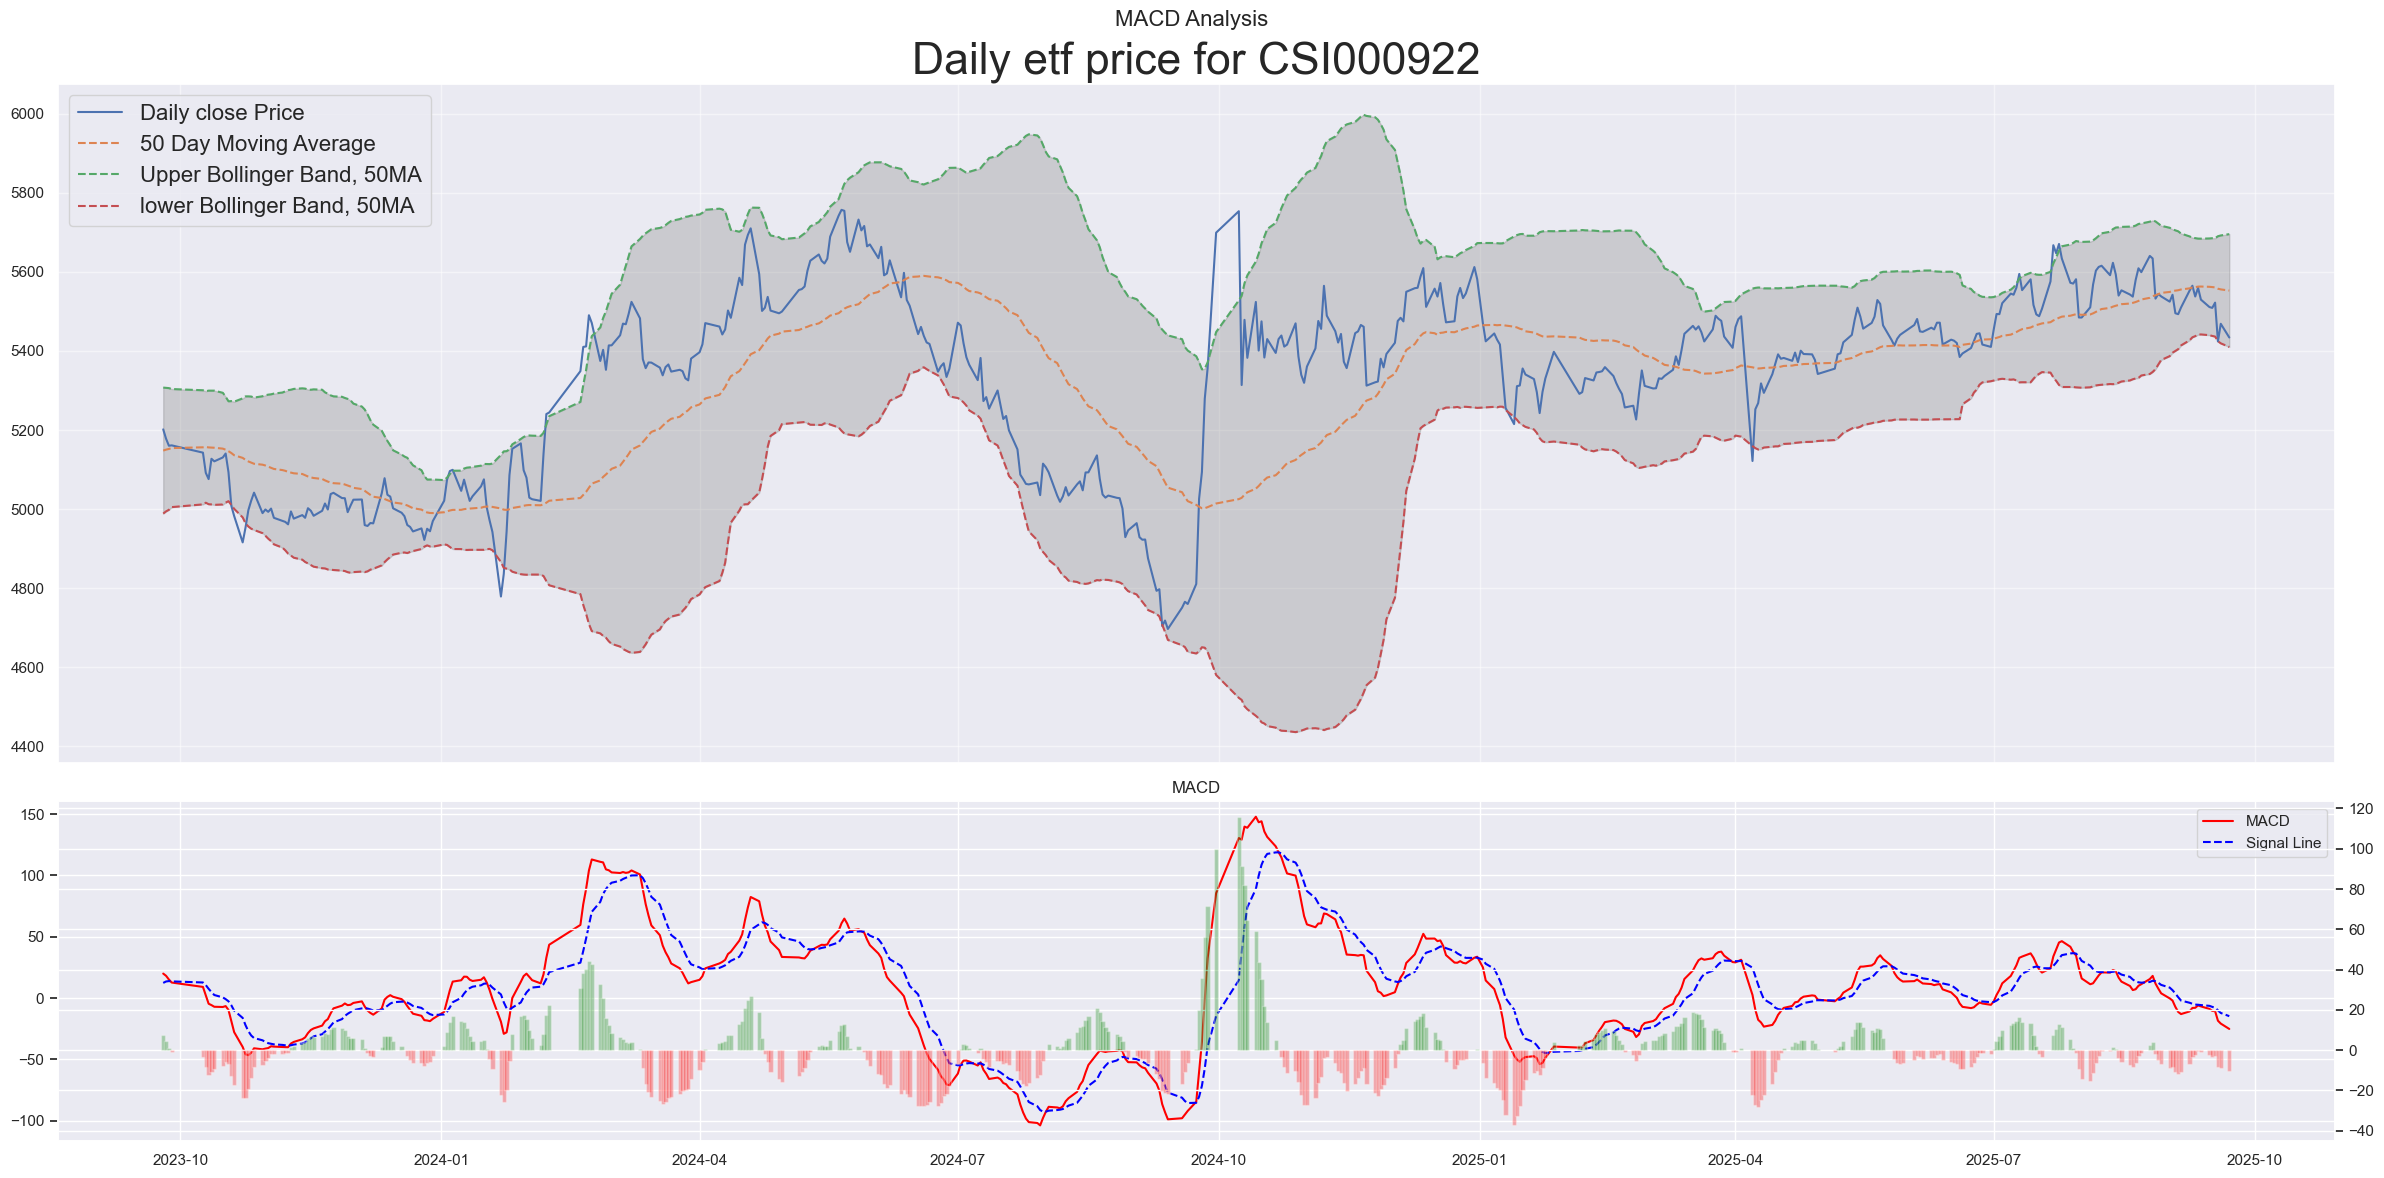

In [2]:
# 红利指数
etf_code = 'csi000922'
etf_strategy(etf_code, source="index").output()

* Current etf price: 16313.37
* Recent high: 19841.06
* Current etf price is at 82.22% of recent high
Latest 20 Day MA: 16910.4
Latest lower Bollinger Band, 20MA: 16457.37
Latest higher Bollinger Band, 20MA: 17363.43
Latest 50 Day MA: 16378.65
Latest lower Bollinger Band, 50MA: 15097.94
Latest higher Bollinger Band, 50MA: 17659.35
Latest 50 Day EMA: 16505.81
Latest 120 Day MA: 16210.06
Latest 200 Day MA: 16119.62
Latest 200 Day EMA: 16241.69
Latest 10 Week MA: 16401.9
Latest 20 Week MA: 16148.18
Latest 30 Week MA: 16208.15
Latest 40 Week MA: 16053.22
Latest Lower Weekly Bollinger Band, 20MA: 15189.84
Latest Higher Weekly Bollinger Band, 20MA: 17106.53

Latest RSI: 39.1 
Latest MACD Divergence: -88.2315 
20MA crosses 50MA at 443.56
20MA break point: 16897.85
20MA lower Bollinger Band break point: 16374.19
20MA Upper Bollinger Band break point: 17421.5
50MA break point: 16394.14
50MA lower Bollinger Band break point: 15025.38
50MA Upper Bollinger Band break point: 17762.91
120MA break po

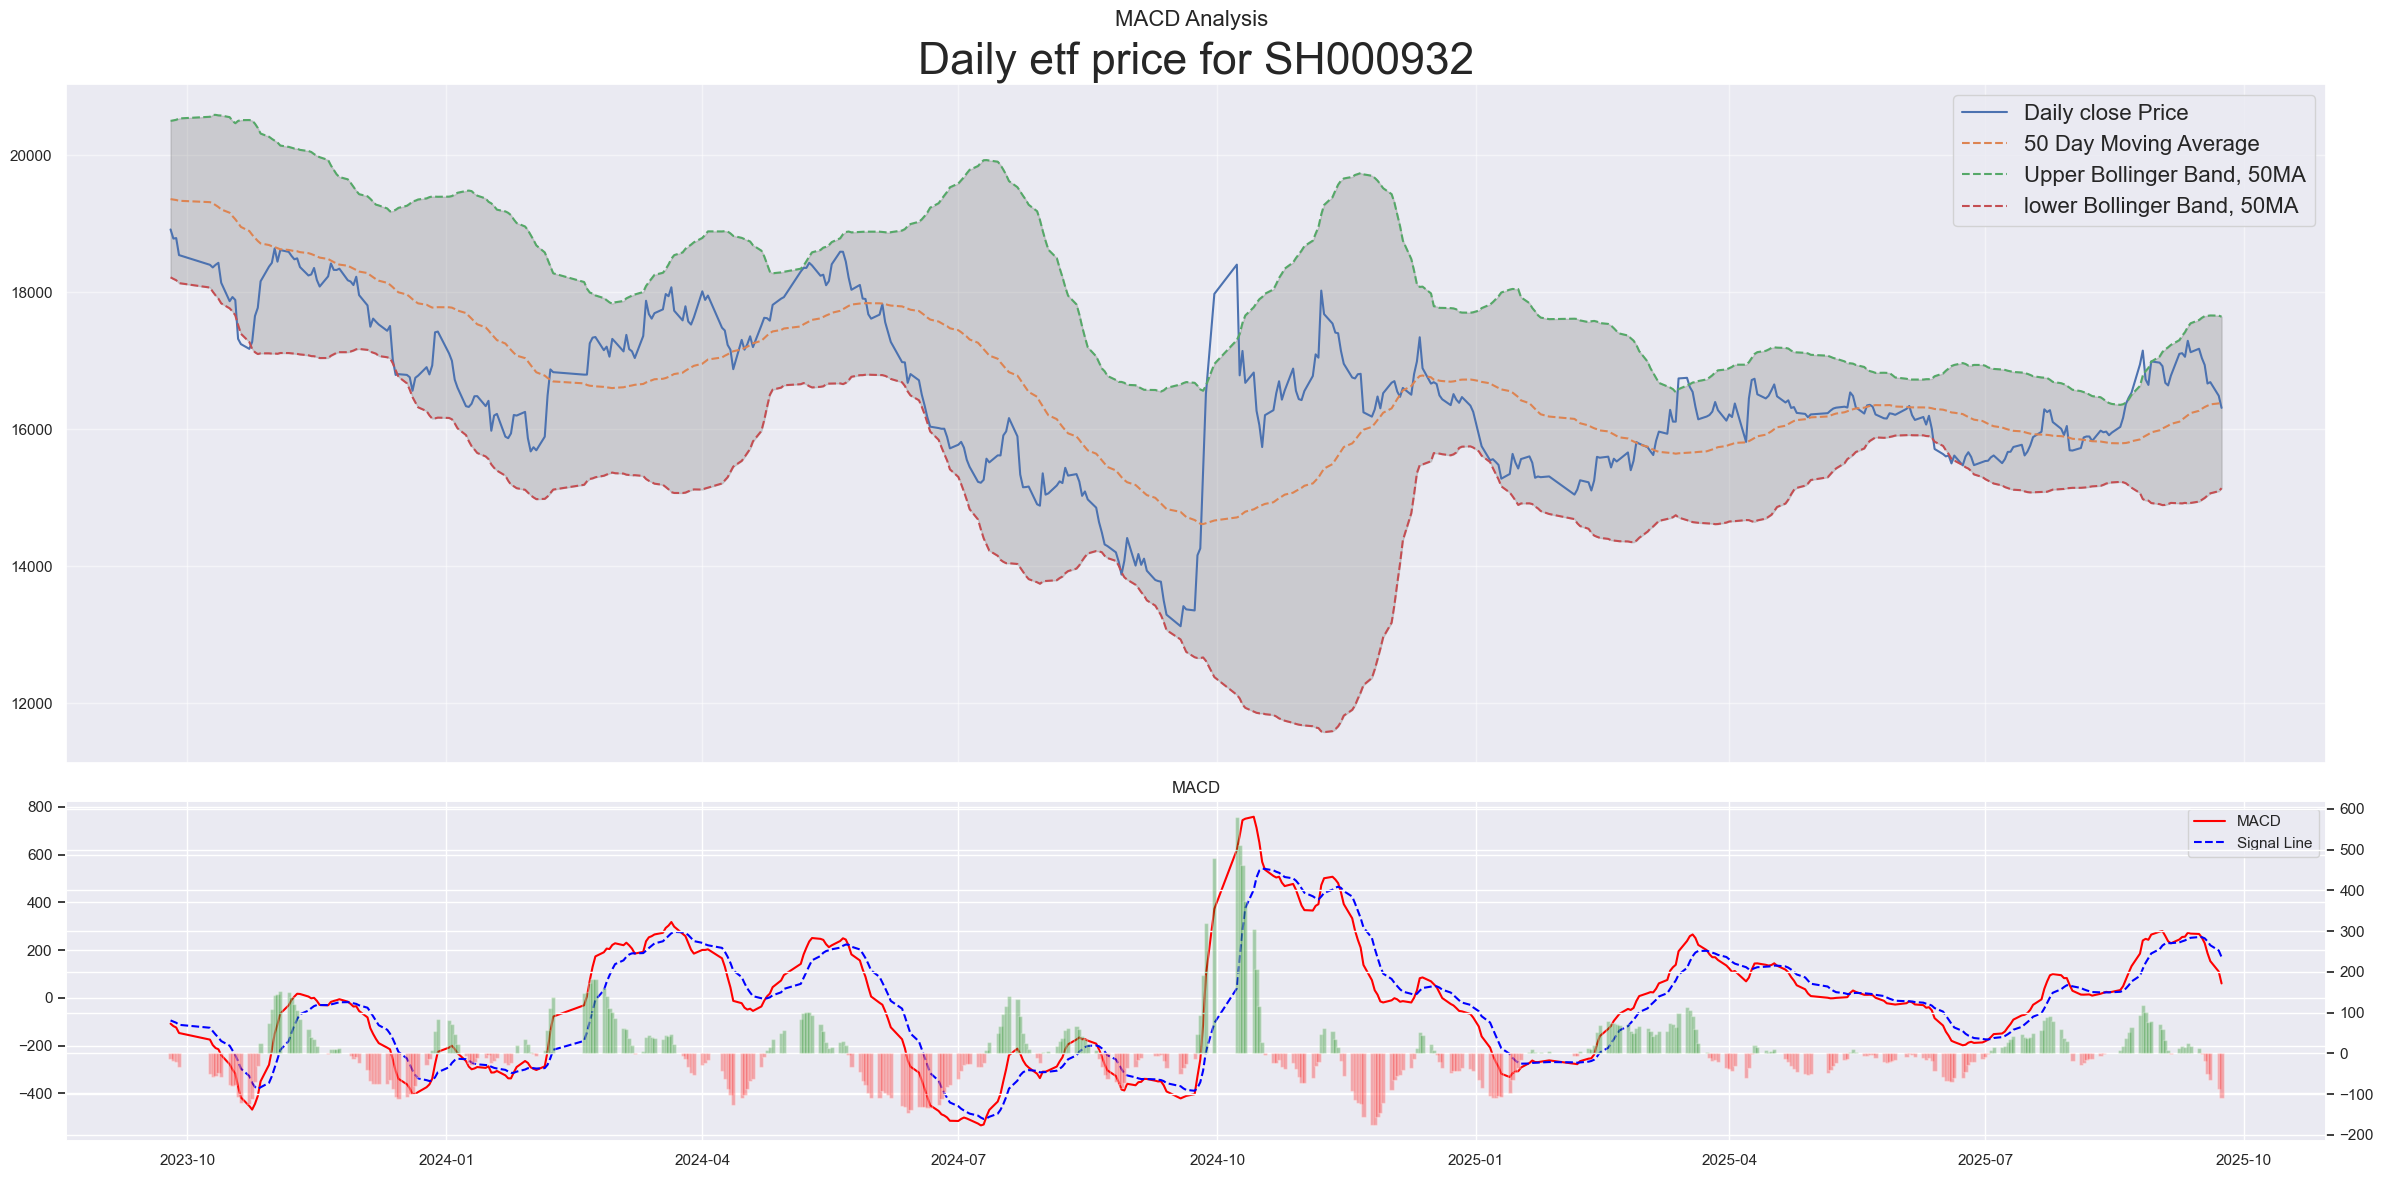

In [3]:
# 中证消费
etf_code = 'sh000932'
etf_strategy(etf_code, source="index").output()

### Test a "momentum driven" strategy

In [ ]:
def backtest_momentum_strategy(price_df, initial_cash=100_000, cycle=21, window=20, sell_early=False):
    """
    Backtest the momentum strategy with X-trading-day evaluation cycle.
    Returns:
        result_df: Daily portfolio value DataFrame
        actions_df: Log of only buy/sell actions
    """
    price_df = price_df.sort_index()
    
    # cycle-day moving average
    ma = price_df.rolling(window=window).mean()
    
    # cycle-day % change
    pct_change = price_df.pct_change(cycle)
    
    # Portfolio state
    cash = initial_cash
    shares = 0
    current_stock = None
    portfolio_values = []
    actions = []

    dates = price_df.index
    
    # for i in range(cycle, len(dates)):  # start from the 22nd trading day
    for i in range(cycle, 21*13):  # Check performance for one year
        date = dates[i]
        
        # Step (1): every cycle trading days, rebalance
        if (i - cycle) % cycle == 0:
            # Sell previous stock if any
            if current_stock is not None:
                sell_price = price_df.loc[date, current_stock]
                cash += shares * sell_price
                actions.append([date, "SELL", current_stock, sell_price, shares])
                shares = 0
                current_stock = None
            
            # Find candidates above ma
            candidates = [s for s in price_df.columns 
                          if price_df.loc[date, s] > ma.loc[date, s]]
            
            if candidates:
                # Pick stock with largest cycle-day % change
                stock_changes = pct_change.loc[date, candidates]
                pick = stock_changes.idxmax()
                buy_price = price_df.loc[date, pick]
                current_stock = pick
                shares = cash // buy_price
                cash -= shares * buy_price
                actions.append([date, "BUY", pick, buy_price, shares])
        
        # Step (2): sell early if price drops below ma
        if sell_early and current_stock is not None:
            if price_df.loc[date, current_stock] < ma.loc[date, current_stock]:
                sell_price = price_df.loc[date, current_stock]
                cash += shares * sell_price
                actions.append([date, "SELL_EARLY", current_stock, sell_price, shares])
                shares = 0
                current_stock = None
        
        # Record portfolio value
        if current_stock is not None:
            value = cash + shares * price_df.loc[date, current_stock]
        else:
            value = cash
        portfolio_values.append((date, value))
    
    # Create results DataFrames
    result_df = pd.DataFrame(portfolio_values, columns=["Date", "PortfolioValue"])
    result_df.set_index("Date", inplace=True)
    
    actions_df = pd.DataFrame(actions, columns=["Date", "Action", "Stock", "Price", "Shares"])
    actions_df.set_index("Date", inplace=True)
    
    total_days = len(result_df)
    final_value = result_df["PortfolioValue"].iloc[-1]
    annualized_return = (final_value / initial_cash) ** (252 / total_days) - 1
    
    return result_df, actions_df, annualized_return


def average_annualized_return(price_df, initial_cash=100_000, n_test=100, cycle=21, window=20, sell_early=False):
    """
    Runs the strategy from different starting offsets (0-20) and averages annualized return.
    """
    returns = []
    for offset in range(n_test):  # 100 possible start offsets
        sliced_df = price_df.iloc[offset:].copy()
        if len(sliced_df) < 42:  # ensure enough data for lookback + holding
            continue
        _, _, ann_return = backtest_momentum_strategy(sliced_df, initial_cash, cycle=cycle, window=window, sell_early=sell_early)
        returns.append(ann_return)
    print(f"Average return: {np.mean(returns) if returns else np.nan}")
    print(f"Return STD: {np.std(returns) if returns else np.nan}")

    return returns

In [ ]:
etf_list = [
"516570",
"512820",
"512260",
"512480",
"512580",
"159948",
"562500",
"159819",
"512600",
"560880",
"512400",
# "159697", # history too short
"515880",
"516080",
"159647",
"515220",
"512890",
"512980",
"159940",
"516110",
"513260",
"513060",
"513660",
# "159545", # history too short
"510050",
]
etf_code = etf_list[0]

df_all = ak.fund_etf_hist_em(
            symbol=etf_code.upper(),
            start_date=(datetime.today() - relativedelta(years=5)).strftime('%Y%m%d'),
            end_date=datetime.today().strftime('%Y%m%d'),
            period='daily',  # Default to daily,
            adjust='qfq'
)
df_all = df_all[['日期','收盘']].set_index('日期')
df_all = df_all.rename(columns={'收盘': etf_code})
for etf_code in etf_list[1:]:
    df = ak.fund_etf_hist_em(
            symbol=etf_code.upper(),
            start_date=(datetime.today() - relativedelta(years=5)).strftime('%Y%m%d'),
            end_date=datetime.today().strftime('%Y%m%d'),
            period='daily',  # Default to daily,
            adjust='qfq'
    )[['日期','收盘']].set_index('日期')
    df = df.rename(columns={'收盘': etf_code})
    df_all = pd.merge(df_all, df, left_index=True, right_index=True, how='inner')
df_all

In [ ]:
returns = average_annualized_return(df_all, initial_cash=100000, cycle=21, window=50)

In [ ]:
returns = average_annualized_return(df_all, initial_cash=100000, cycle=21, window=20)

In [ ]:
result_df, actions_df, annualized_return = backtest_momentum_strategy(df_all, cycle=21, window=20)
print(annualized_return)
result_df

In [ ]:
actions_df

In [ ]:
# benchmark
good_etfs = {
    "honglidibo": "512890",
    "hongli": "515180"}
for etf in good_etfs:
    etf_code = good_etfs[etf]
    df_etf = etf_strategy(etf_code, start='20150101').return_result()
    df_etf.set_index('date',inplace=True)
    valid_start_range = range(0, len(df_etf) - 252)
    start_points = np.random.choice(valid_start_range, size=800, replace=False)
    returns = []
    for start in start_points:
        dates = df_etf.index
        initial_date = dates[start]
        end_date = dates[start + 252]
        initial_price = df_etf.loc[initial_date]['close']
        end_price = df_etf.loc[end_date]['close']
        returns.append(end_price/initial_price - 1)
    print(etf)
    print(f"Average return: {np.mean(returns) if returns else np.nan}")
    print(f"Return STD: {np.std(returns) if returns else np.nan}")
    print(f"earning-cost ratio: {abs((np.mean(returns)+1.96*np.std(returns))/(np.mean(returns)-1.96*np.std(returns))) if returns else np.nan}")

In [ ]:
etf_regression("512890", detailed=True)

In [ ]:
etf_regression("515180", detailed=True)